# Situation Awareness Detection

In [3]:
import os

import json
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.io import loadmat
from matplotlib import pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram, resample

EEG_FOLDER = f'../datasets/EEG_data_for_Mental_Attention_State_Detection'

trial = 4
channel = 'F4'

fs = 128

bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 14),
    'Beta': (14, 32),
    'Gamma': (32, 60),
}

data_root = f'{EEG_FOLDER}/EEG_Data'

channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']



def bp_filter(data, f_lo, f_hi, fs):
    """ Digital band pass filter (6-th order Butterworth)
    Args:
        data: np.ndarray, time along axis 0
        (f_lo, f_hi): frequency band to extract [Hz]
        fs: sampling frequency [Hz]
    Returns:
        data_filter: band-pass filtered data, same shape as data """
    f_ny = fs / 2.  # Nyquist frequency
    b_lo = f_lo / f_ny  # normalized frequency [0..1]
    b_hi = f_hi / f_ny  # normalized frequency [0..1]
    # band-pass filter parameters
    p_lp = {"N": 6, "Wn": b_hi, "btype": "lowpass", "analog": False, "output": "ba"}
    p_hp = {"N": 6, "Wn": b_lo, "btype": "highpass", "analog": False, "output": "ba"}
    bp_b1, bp_a1 = butter(**p_lp)
    bp_b2, bp_a2 = butter(**p_hp)
    data_filter = filtfilt(bp_b1, bp_a1, data, axis=0)
    data_filter = filtfilt(bp_b2, bp_a2, data_filter, axis=0)
    return data_filter


def get_EEG_data(data_root, filename):
    # Extract the data from one of these files.
    hz = fs
    #filename = 'eeg_record30.mat'
    mat = loadmat(f'{data_root}/{filename}')
    data = pd.DataFrame.from_dict(mat["o"]["data"][0, 0])

    # Limit the data to the 7 valid EEG leads.
    dat = data.filter(list(range(3, 17)))
    dat.columns = list(range(1, 15))
    dat = dat.filter([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17], axis=1)
    labels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8',
              'AF4']  # FP2 should really be AF4
    dat.columns = labels

    # Filter the data, high pass .5 Hz, low pass 62 Hz.
    lo, hi = .5, 62
    # Do the filtering.
    datf = bp_filter(dat.to_numpy(), lo, hi, hz)

    # Convert back to a dataframe.
    dat = pd.DataFrame({c: datf[:, i] for i, c in enumerate(labels)})

    return dat


def get_trial_data(trial):
    dat = get_EEG_data(data_root, f'eeg_record{trial}.mat')
    return dat

def spikes_to_events(spikes):
    return np.where(spikes == 1)[0]

def get_stats_resonator(freq):
    resonator_stats_file = '../filters4_xi0/clk_1536000/chirp'
    if freq < 10:
        freq *= 100
    else:
        freq *= 10
    resonators_opt = np.array([int(resonator[2:-5]) for resonator in os.listdir(resonator_stats_file)])
    chosen_resonators = resonators_opt[np.argmin(np.abs(resonators_opt - freq))]
    with open(f'{resonator_stats_file}/f_{chosen_resonators}.json') as f:
        result = json.load(f)
    return result

In [4]:
example_data = get_trial_data(trial)
example_data = example_data.iloc[0:30 * 60 * 128]

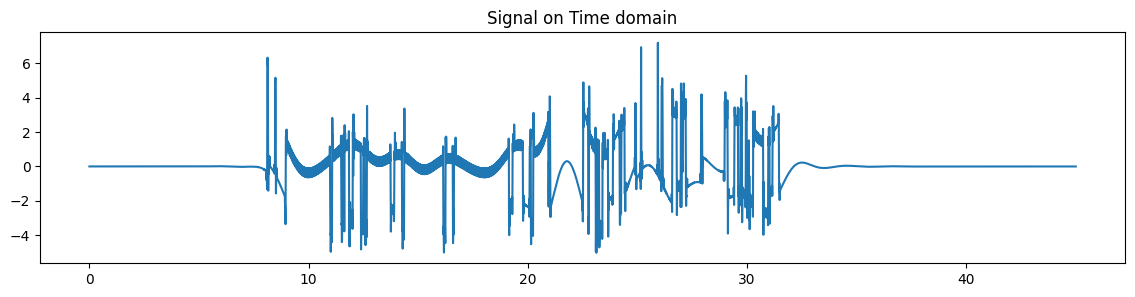

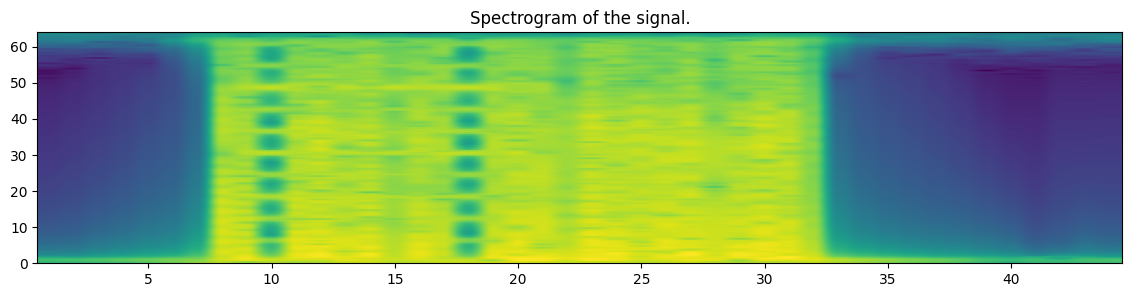

In [5]:
time_start_s = 1670
time_end_s = 1715
sliced_data = example_data[channel][time_start_s*fs:time_end_s*fs]
plt.figure(figsize=(14, 3))
plt.plot(np.linspace(0, time_end_s-time_start_s, len(sliced_data)) , sliced_data)
plt.title('Signal on Time domain')

plt.figure(figsize=(14, 3))
plt.title('Spectrogram of the signal.')
plt.specgram(sliced_data, Fs=fs)
None

In [6]:


def plot_spectrogram(data, channel_name, fs, fmin, fmax, show=True):
    # plot the spectrogram
    if show:
        plt.figure(figsize=(14, 5))
    f, t, Sxx = spectrogram(data, fs, noverlap=0, nperseg=fs)
    Sxx = Sxx[:, :-1]
    if show:
        plt.ylim(fmin, fmax)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title(f'ch={channel_name} fs={fs} band=({fmin} - {fmax})Hz')
        plt.imshow(Sxx, aspect='auto',
                   cmap='jet', origin='lower',
                   extent=[t[0], t[-1], f[0], f[-1]],
                   )
        plt.colorbar()
    return Sxx


def fft_spectogram2bins(Sxx, window, normalize_band=True):
    bins_count = len(Sxx[0]) // window + 1
    bin_sxx = np.zeros((len(bands), bins_count))

    # dict to array
    for ch_i, (f_min, f_max) in enumerate(bands.values()):
        alpha = 1
        if normalize_band:
            alpha = (f_max - f_min)
        for i in range(bins_count):
            bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i * window:(i + 1) * window]) / alpha
        bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i * window:]) / alpha

    return bin_sxx


def spikes_event_spectrogram(clk_freq, events, window_ms, duration_s=None):
    window = clk_freq / 1000 * window_ms
    if duration_s is None:
        duration_s = events[-1] + 1
    else:
        duration_s *= clk_freq
    N = duration_s / window
    if N != int(N):
        N = int(N) + 1
    else:
        N = int(N)
    bins = np.zeros(N, dtype=int)
    unique_indices, counts = np.unique(events // window, return_counts=True)
    bins[unique_indices.astype(int)] = counts
    return bins


def spikes_to_bands(spikes_spectrogram, freqs, normalize_band=True):
    freqs = np.array(freqs)
    bands_spectrogram = np.zeros((len(bands), spikes_spectrogram.shape[1]))
    bands_spectrogram[0] = np.sum(spikes_spectrogram[(freqs >= 1) & (freqs < 4)], axis=0)
    bands_spectrogram[1] = np.sum(spikes_spectrogram[(freqs >= 4) & (freqs < 8)], axis=0)
    bands_spectrogram[2] = np.sum(spikes_spectrogram[(freqs >= 8) & (freqs < 14)], axis=0)
    bands_spectrogram[3] = np.sum(spikes_spectrogram[(freqs >= 14) & (freqs < 32)], axis=0)
    bands_spectrogram[4] = np.sum(spikes_spectrogram[(freqs >= 32) & (freqs < 62)], axis=0)
    if normalize_band:
        bands_spectrogram[0] /= sum(freqs[(freqs >= 1) & (freqs < 4)])
        bands_spectrogram[1] /= sum(freqs[(freqs >= 4) & (freqs < 8)])
        bands_spectrogram[2] /= sum(freqs[(freqs >= 8) & (freqs < 14)])
        bands_spectrogram[3] /= sum(freqs[(freqs >= 14) & (freqs < 32)])
        bands_spectrogram[4] /= sum(freqs[(freqs >= 32) & (freqs < 62)])
    return bands_spectrogram


def plot_bins(Sxx, duration, labels, annotate=True, rotate_annotate=False, show=True, colorbar=True, gridlines=False,
              axs=None, fig=None,
              vmin=None, vmax=None, fontsize=None):
    if axs is None:
        fig, ax = plt.subplots(figsize=(14, 5))
    else:
        ax = axs
    im = ax.imshow(Sxx, aspect='auto',
                   cmap='jet', origin='lower',
                   extent=[0, duration, 0, len(Sxx)],
                   vmin=vmin, vmax=vmax
                   )

    ax.set_yticks(np.arange(.5, len(Sxx) + .5), labels=labels, fontsize=fontsize)
    if annotate:
        bin_size = duration / len(Sxx[0])
        rotation_degree = 90 * rotate_annotate
        for i in range(len(Sxx)):
            for j in range(len(Sxx[i])):
                text = ax.text(j * bin_size + bin_size * .5, i + .5, f'{Sxx[i, j]:.4f}',
                               rotation=rotation_degree,
                               ha="center", va="center", color="white")

    if gridlines:
        ax.set_yticks(np.arange(0, len(labels)), minor=True)
        ax.grid(which='minor', color='grey', linestyle='-', linewidth=1)
    fig.tight_layout()
    if colorbar:
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_ticks([])
    if show:
        plt.show()
    return ax


(5, 45)

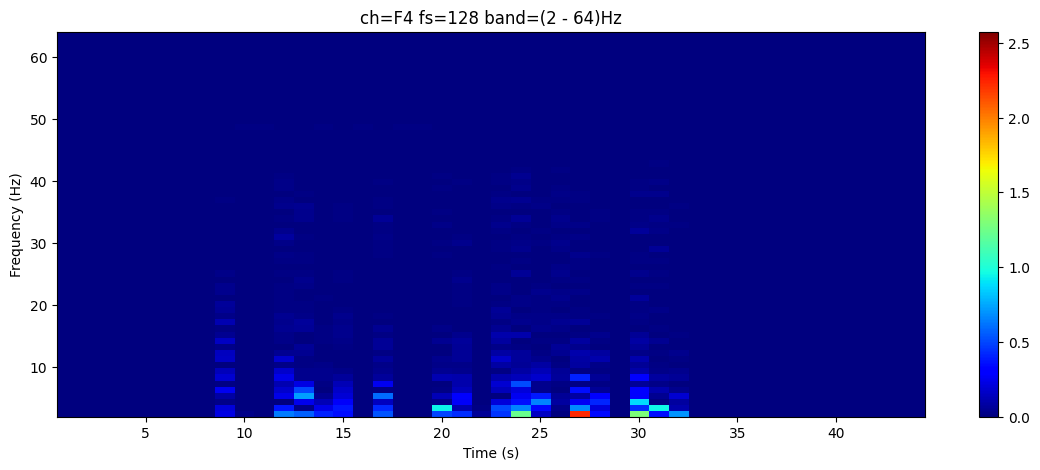

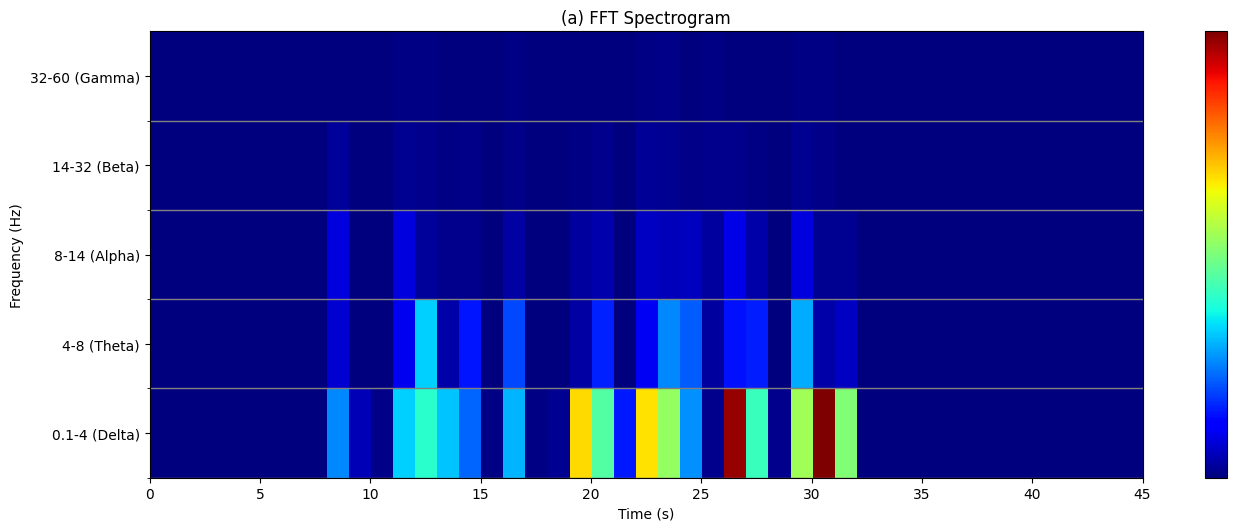

In [7]:
fft_spectogram = plot_spectrogram(sliced_data, channel_name=channel, fs=fs, fmin=2, fmax=64, show=True)
fft_bin_spectogram = fft_spectogram2bins(fft_spectogram, 1)
labels = ['0.1-4', '4-8', '8-14', '14-32', '32-60']
labels = [f'{f} ({band})' for f, band in  zip(labels, bands.keys())]
ax = plot_bins(fft_bin_spectogram, len(sliced_data)/fs, labels, annotate=False, rotate_annotate=True,
               show=False, colorbar=True, gridlines=True)
plt.title('(a) FFT Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mean amplitude per band')
plt.ylabel('Frequency (Hz)')


fft_bin_spectogram.shape

In [8]:
clk_resonators = {
    15360: [1.1, 1.3, 1.6, 1.9, 2.2, 2.5, 2.88, 3.05, 3.39, 3.7, 4.12, 4.62, 5.09, 5.45, 5.87, 6.36, 6.8, 7.6, 8.6],
    153600: [10.5, 11.5, 12.8, 15.8, 16.6, 19.4, 22.0, 24.8, 28.4, 30.5, 34.7, 37.2, 40.2, 43.2, 47.7, 52.6, 57.2]
}

main_clk = max(clk_resonators.keys())

In [25]:
from tqdm import tqdm
from sctn.resonator import resonator


# number of samples in the original and resampled signals
def resample_signal(f_new, f_source, data):
    n_samples_orig = data.shape[0]
    n_samples_new = int(n_samples_orig * f_new / f_source)

    # resample the signal
    return resample(data, n_samples_new)

output = {}

count_resonators = len(sum(clk_resonators.values(), []))
with tqdm(total=count_resonators) as pbar:
    for clk_freq, list_of_f0 in clk_resonators.items():
        output[clk_freq] = []
        sliced_data_resampled = resample_signal(clk_freq, fs, sliced_data)
        for f0 in list_of_f0:
            my_resonator = resonator(
                freq0=f0,
                clk_freq=clk_freq
            )
            my_resonator.log_out_spikes(-1)
            output_neuron = my_resonator.layers_neurons[-1].neurons[-1]
            my_resonator.input_full_data(sliced_data_resampled)
            # extract the spikes without the appended zeros
            output[clk_freq].append(output_neuron.out_spikes())
            pbar.update(1)


100%|██████████| 36/36 [13:17<00:00, 22.15s/it]


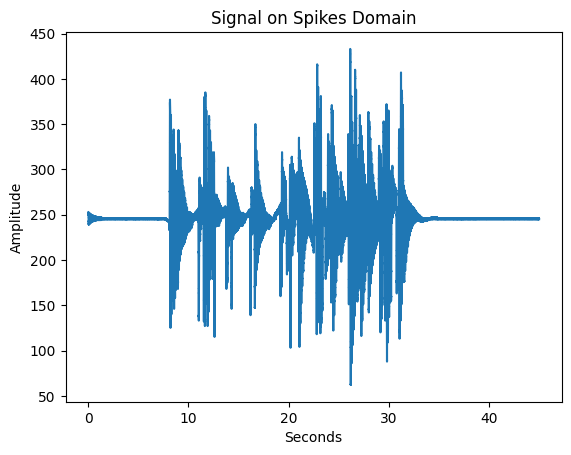

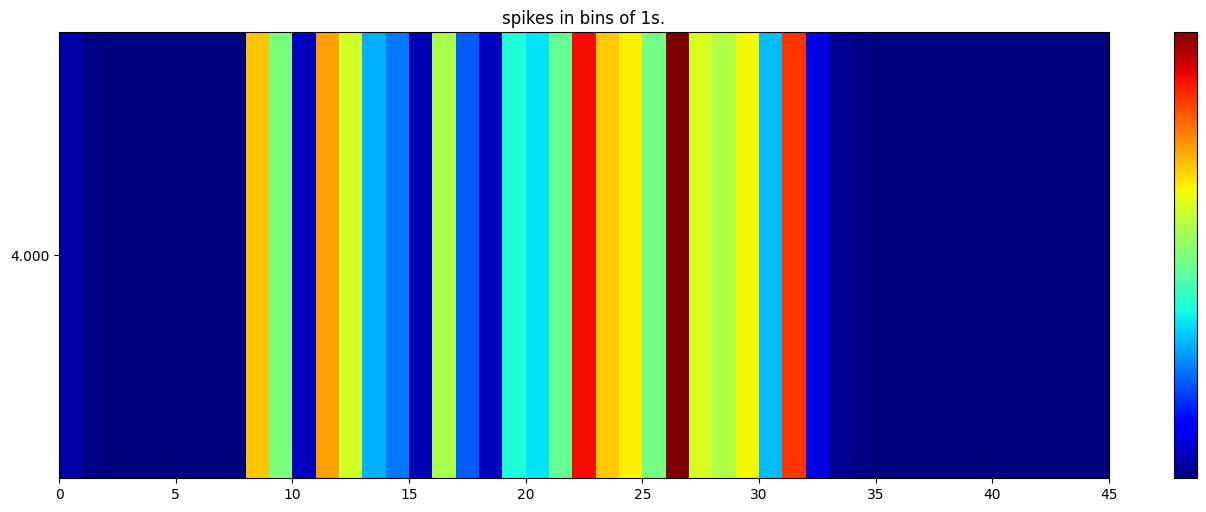

In [11]:
duration = time_end_s - time_start_s
clk_freq = 153600
events = output[clk_freq][0]
y_spikes = np.zeros(clk_freq * duration)
y_spikes[events] = 1
y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')
plt.plot(np.linspace(0, duration, len(y_spikes)), y_spikes)
plt.xlabel('Seconds')
plt.ylabel('Amplitude')
plt.title('Signal on Spikes Domain')
plt.show()

spikes_spectrogram = np.zeros((1, (duration * 1000)// 10))
max_spikes_spectrogram = np.zeros((1, (duration * 1000) // 1000))
spikes_spectrogram[0] = spikes_event_spectrogram(clk_freq, events, 10, duration)
max_spikes_spectrogram[0] = spikes_spectrogram[0].reshape(-1, len(spikes_spectrogram[0])//len(max_spikes_spectrogram[0])).max(axis=1)

plot_bins(max_spikes_spectrogram, max_spikes_spectrogram.shape[1], labels=['4.000'], annotate=False, show=False, rotate_annotate=True)
plt.title('spikes in bins of 1s.')
plt.show()

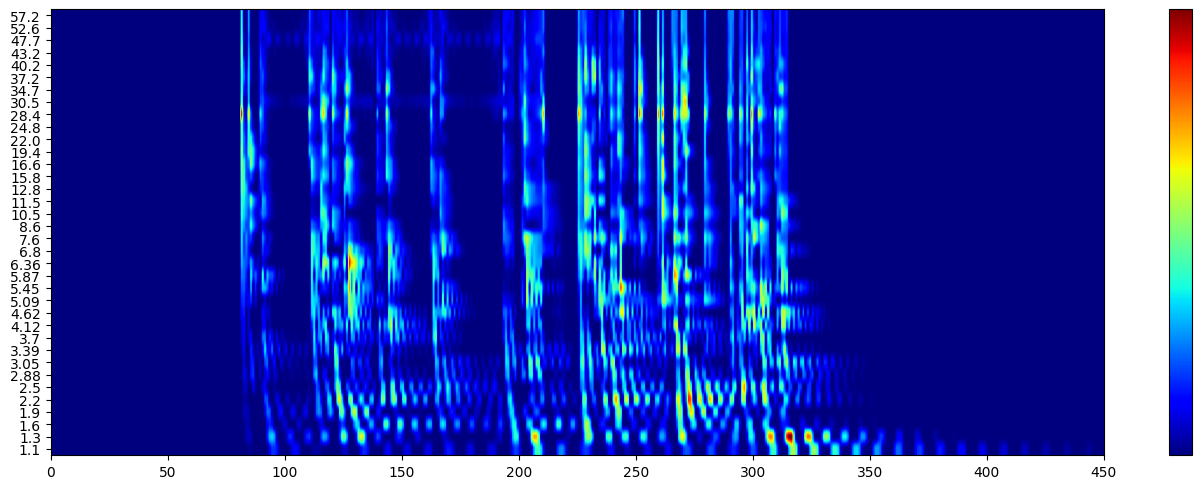

<Axes: >

In [12]:
def events_to_max_spectrogram(resonators_by_clk, duration):
    spikes_array = sum(resonators_by_clk.values(), start=[])

    max_spikes_spectrogram = np.zeros((len(spikes_array), (duration * 1000) // 100))
    i = 0
    for clk_freq, spikes_arrays in resonators_by_clk.items():
        for events in spikes_arrays:
            spikes_spectrogram = spikes_event_spectrogram(clk_freq, events, 10)
            max_spikes_spectrogram[i] = spikes_spectrogram.reshape(-1, len(spikes_spectrogram)//len(max_spikes_spectrogram[i])).max(axis=1)
            max_spikes_spectrogram[i] *= main_clk/clk_freq
            max_spikes_spectrogram[i] -= np.mean(max_spikes_spectrogram[i])
            max_spikes_spectrogram[i][max_spikes_spectrogram[i] < 0] = 0
            i += 1
    return max_spikes_spectrogram

max_spikes_spectrogram = events_to_max_spectrogram(output, duration)
plot_bins(max_spikes_spectrogram, max_spikes_spectrogram.shape[1], labels=sum(clk_resonators.values(), []), annotate=False)

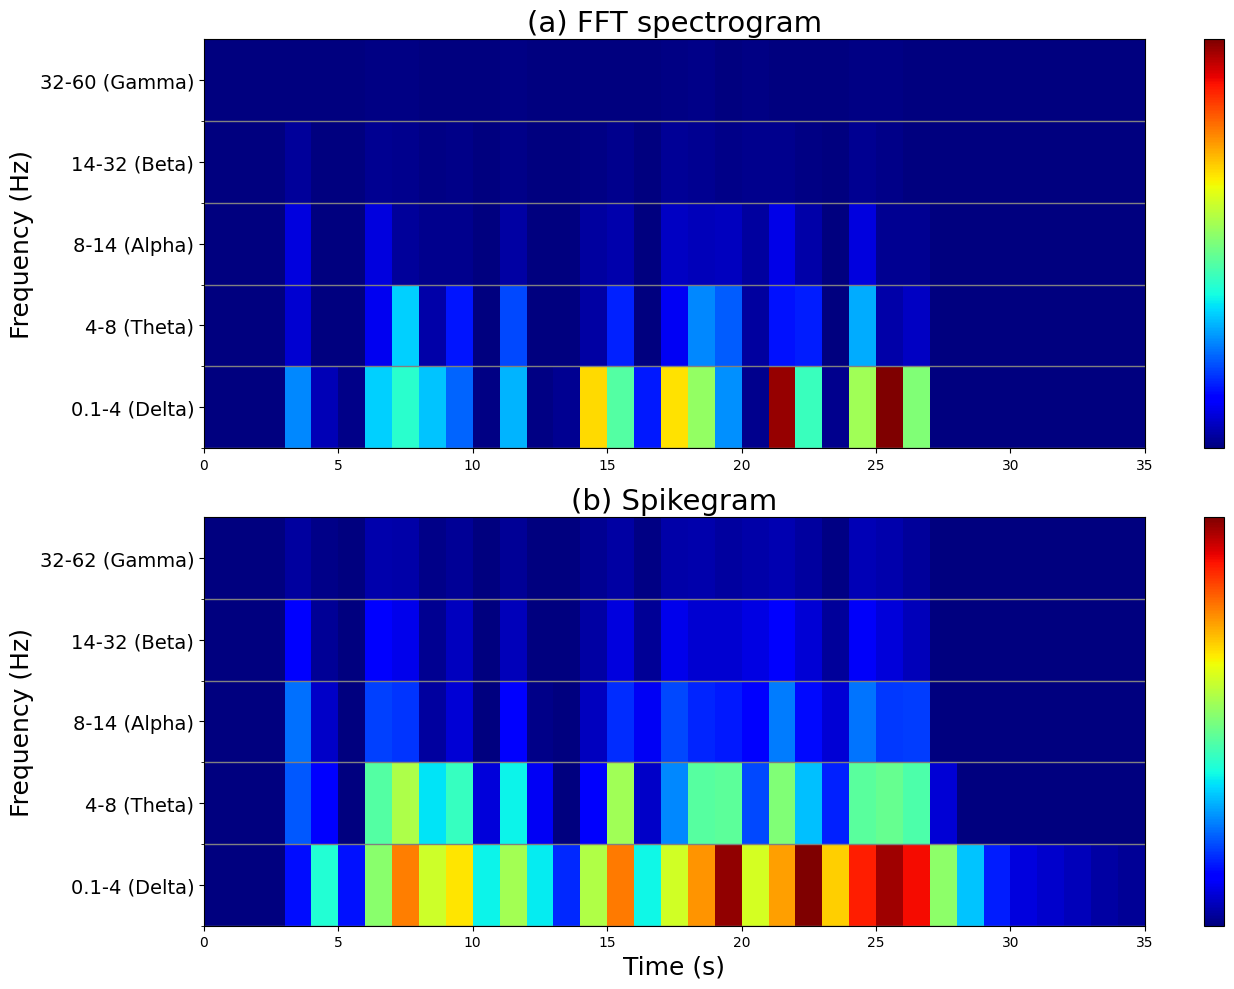

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(14, 10))
plt.rcParams["font.family"] = "Times New Roman"
ax = axs[0]
fft_bin_spectogram_ = fft_bin_spectogram[:, 5:40]
duration = len(fft_bin_spectogram_[0])
plot_bins(fft_bin_spectogram_, duration, labels, annotate=False, rotate_annotate=True,
               show=False, colorbar=True, gridlines=True, fig=fig, axs=ax)
ax.set_title('(a) FFT spectrogram', fontsize=21)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.tick_params(axis='y', labelsize=14)


full_resonators_freqs = sum(clk_resonators.values(), [])
spikes_bands_spectrogram = spikes_to_bands(max_spikes_spectrogram, full_resonators_freqs)

spikes_bands_spectrogram = spikes_bands_spectrogram.reshape(spikes_bands_spectrogram.shape[0], spikes_bands_spectrogram.shape[1]//10, 10).sum(axis=2)
labels = ['0.1-4', '4-8', '8-14', '14-32', '32-62']
labels = [f'{f} ({band})' for f, band in  zip(labels, bands.keys())]

ax = axs[1]
spikes_bands_spectrogram_ = spikes_bands_spectrogram[:, 5:40]
plot_bins(spikes_bands_spectrogram_, duration, labels=labels, annotate=False,
          rotate_annotate=True, show=False, colorbar=True, gridlines=True, fig=fig, axs=ax)

ax.set_title('(b) Spikegram', fontsize=21)
ax.set_xlabel('Time (s)', fontsize=18)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
fig.tight_layout()
fig.savefig('spec_vs_spikes.pdf')

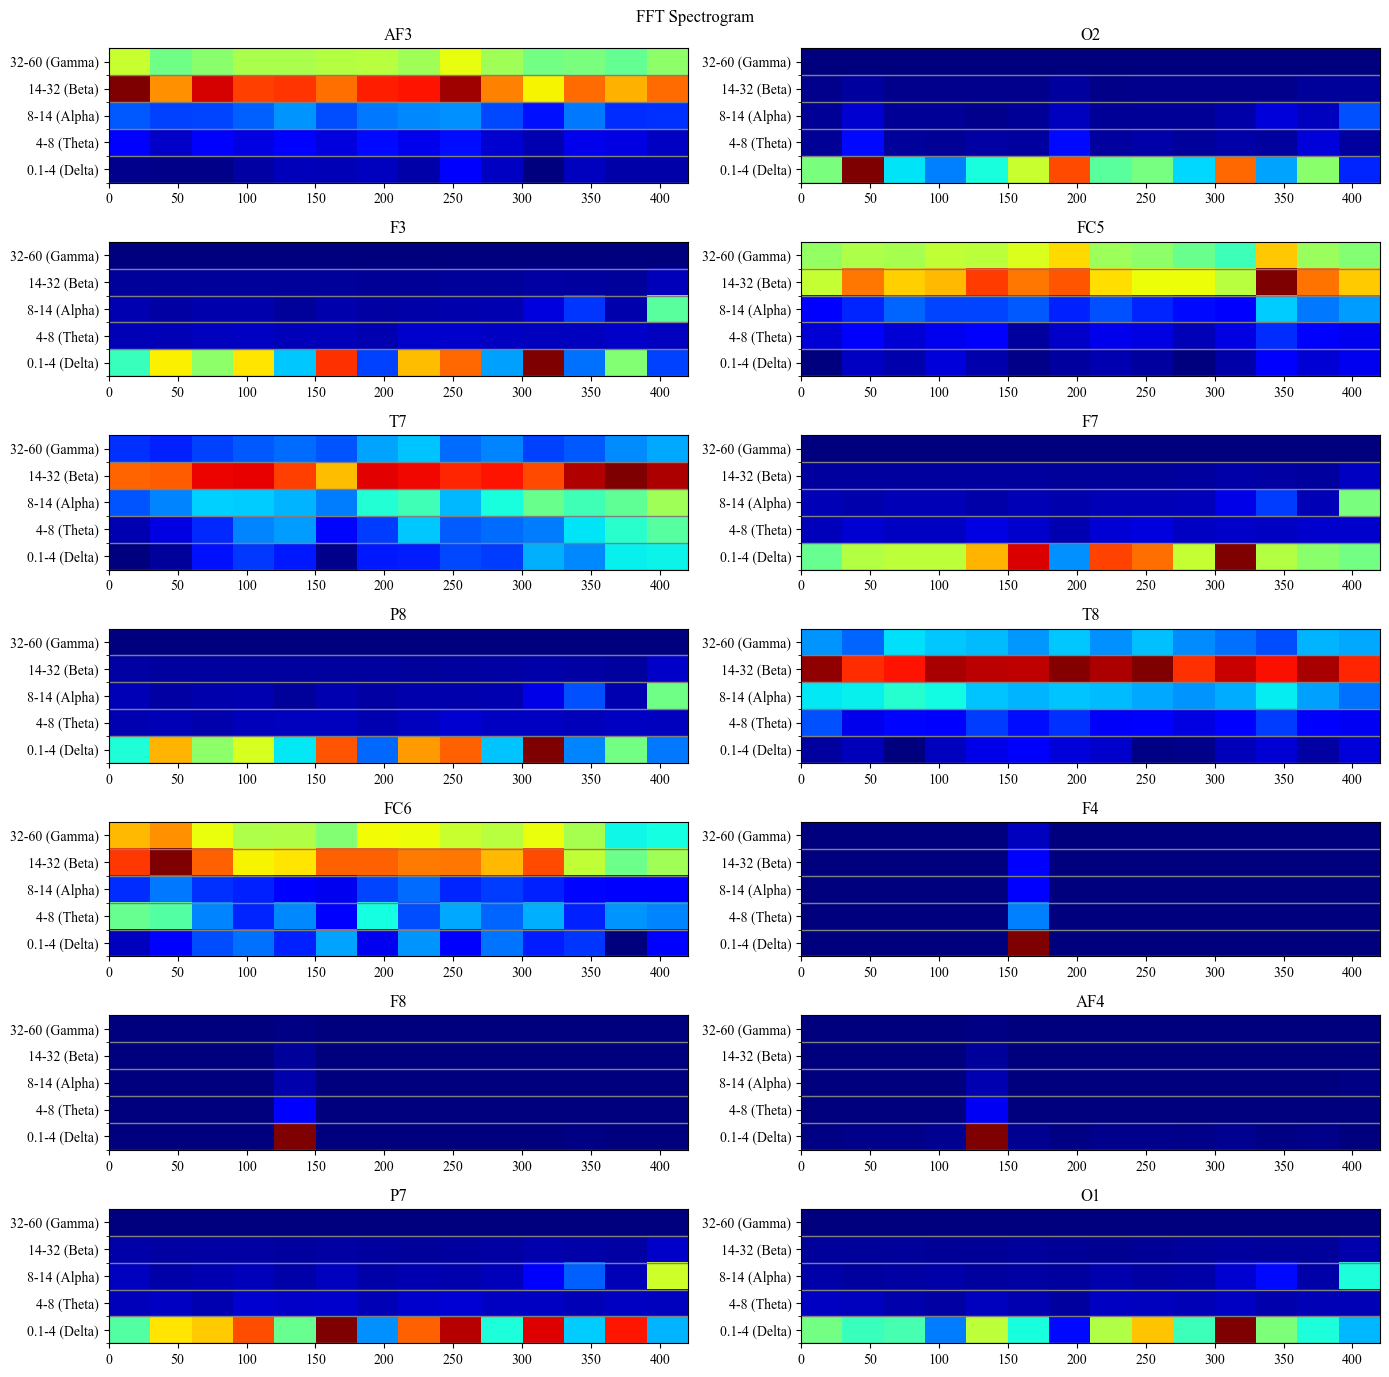

In [15]:

time_start_s = 13 * 60
time_end_s = 20 * 60
example_data = get_trial_data(4)
fft_bin_spectogram = {}
min_value = np.inf
max_value = -np.inf
duration = time_end_s - time_start_s

fig, axs = plt.subplots(7, 2, figsize=(14, 14))
for ch in channels:
    sliced_data = example_data[ch][time_start_s*fs:time_end_s*fs]

    fft_spectogram = plot_spectrogram(sliced_data, channel_name=ch, fs=fs, fmin=.5, fmax=64, show=False)
    fft_bin_spectogram[ch] = fft_spectogram2bins(fft_spectogram, 30, normalize_band=False)

for i, ch in enumerate(channels):
    ax = axs[i//2][i%2]
    labels = ['0.1-4', '4-8', '8-14', '14-32', '32-60']
    labels = [f'{f} ({band})' for f, band in  zip(labels, bands.keys())]
    plot_bins(fft_bin_spectogram[ch], duration, labels, annotate=False, rotate_annotate=True,
                   show=False, colorbar=False, gridlines=True, axs=axs[i//2][i%2], fig=fig
              )
    axs[i//2][i%2].set_title(ch)
plt.suptitle(f'FFT Spectrogram')
plt.tight_layout()

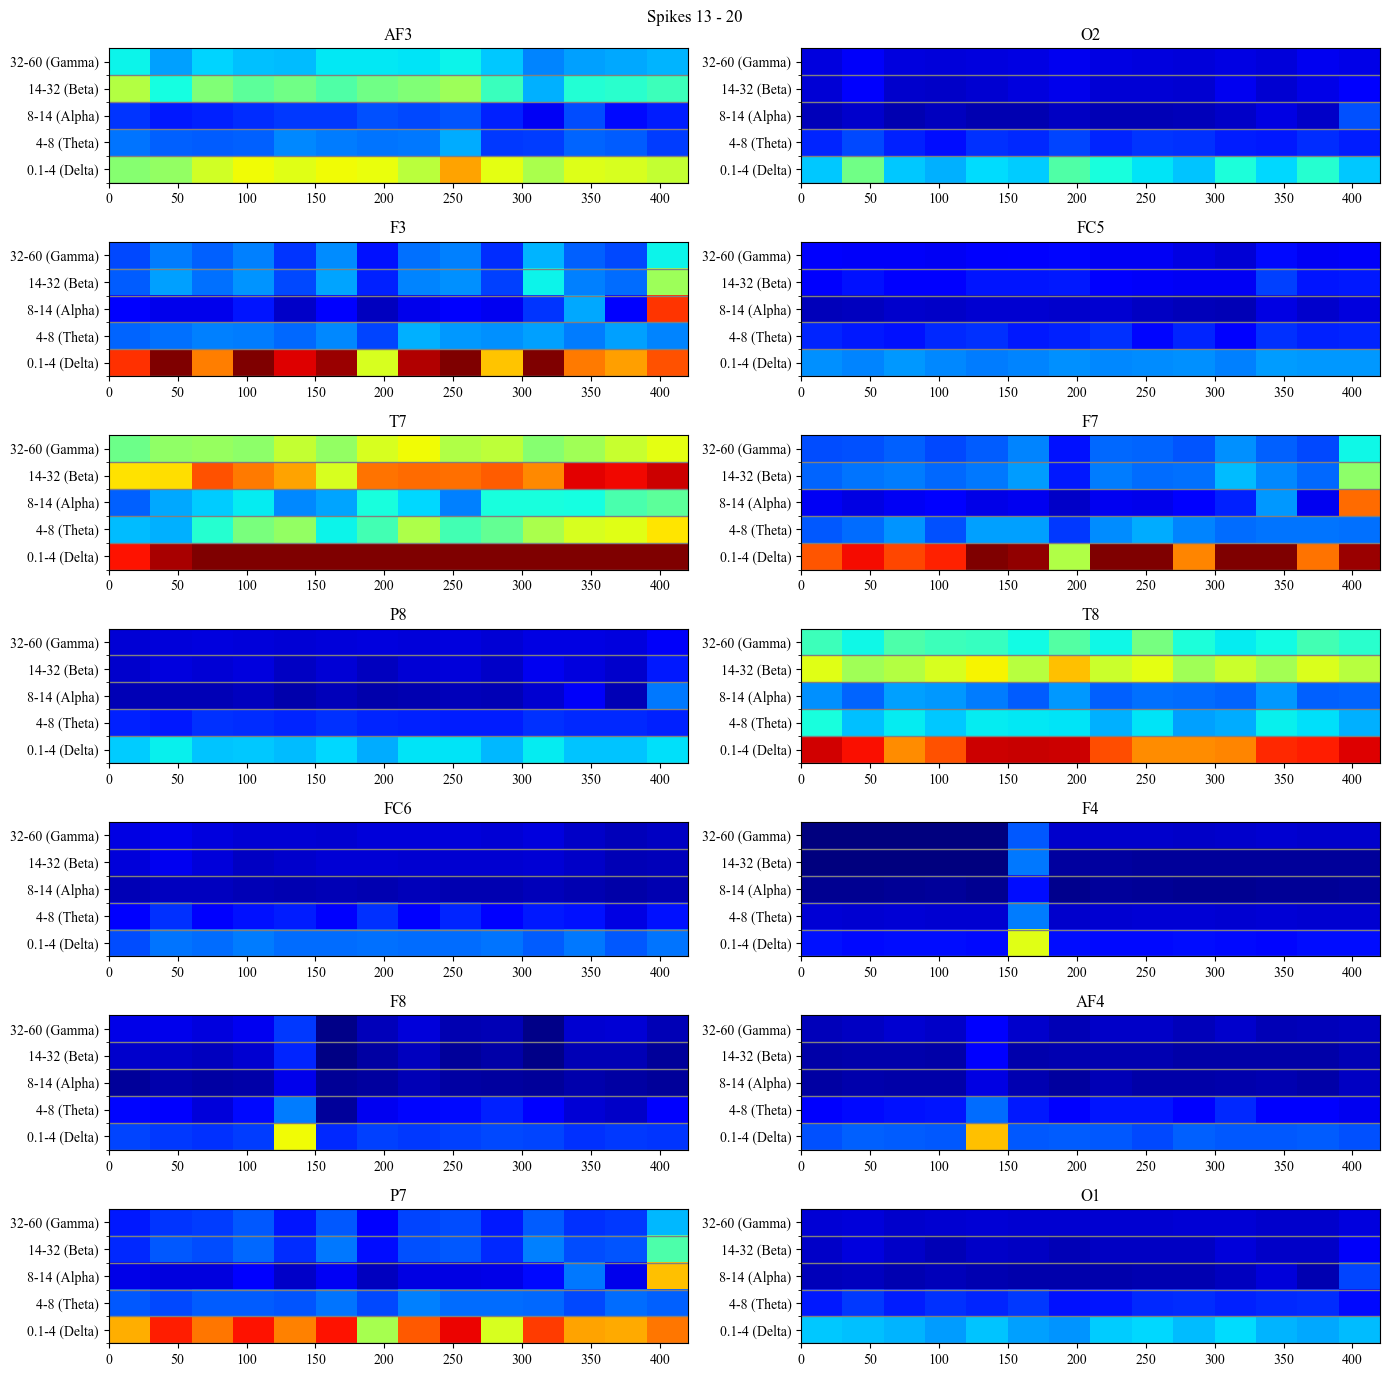

In [17]:
def bands_spikegrams(base_minute, last_minute):
    if (base_minute - 1) // 10 != (last_minute - 1) // 10:
        raise ValueError('minutes from different labels')
    label = 'focus'
    if base_minute > 10:
        label = 'unfocus'
    if base_minute > 20:
        label = 'drowsed'
        
    path = Path(f'../datasets/EEG_data_for_Mental_Attention_State_Detection/EEG_spikes/4/{label}/')
    duration = 60 * (last_minute - base_minute)
    
    spikes_vmin = np.inf
    spikes_vmax = -np.inf
    spikes_bands_spectrogram = {}

    for ch in channels:
        channel_output_dict = {
            15360: {},
            153600: {},
        }
        for minute in range(base_minute, last_minute):
            str_minute = str(minute)
            for str_clk_freq in os.listdir(path / str_minute / ch):
                clk_freq = int(str_clk_freq)
                resonators_path = path / str_minute / ch / str_clk_freq
                for resonator_output in os.listdir(resonators_path):
                    resonator_freq = float(resonator_output[:-4])
                    events = spikes_to_events(np.load(resonators_path / resonator_output)['spikes']) + (60 * clk_freq * (minute - base_minute))
                    if resonator_freq not in channel_output_dict[clk_freq]:
                        channel_output_dict[clk_freq][resonator_freq] = events
                    else:
                        channel_output_dict[clk_freq][resonator_freq] = np.concatenate([
                            channel_output_dict[clk_freq][resonator_freq],
                            events
                        ])
    
        channel_output = {
            15360: [],
            153600: []
        }
        for f0 in full_resonators_freqs:
            if f0 < 10:
                channel_output[15360].append(channel_output_dict[15360][f0])
            else:
                channel_output[153600].append(channel_output_dict[153600][f0])
    
        max_spikes_spectrogram = events_to_max_spectrogram(channel_output, duration=duration)
        spikes_bands_spectrogram[ch] = spikes_to_bands(max_spikes_spectrogram, full_resonators_freqs, normalize_band=False)
        spikes_bands_spectrogram[ch] = spikes_bands_spectrogram[ch].reshape(spikes_bands_spectrogram[ch].shape[0],
                                                                            spikes_bands_spectrogram[ch].shape[1]//(10*30), (10*30)).sum(axis=2)

        spikes_vmin = min(spikes_vmin, spikes_bands_spectrogram[ch].min())
        spikes_vmax = max(spikes_vmax, spikes_bands_spectrogram[ch].max())
    
    return spikes_bands_spectrogram, spikes_vmin, spikes_vmax
    

base_minute, last_minute = 13, 20
spikes_bands_spectrogram, spikes_vmin, spikes_vmax = bands_spikegrams(base_minute, last_minute)
fig, axs = plt.subplots(7, 2, figsize=(14, 14))
for i, (ch, bin_specgram) in enumerate(spikes_bands_spectrogram.items()):
    labels = ['0.1-4', '4-8', '8-14', '14-32', '32-60']
    labels = [f'{f} ({band})' for f, band in  zip(labels, bands.keys())]
    plot_bins(bin_specgram, duration, labels, annotate=False, rotate_annotate=True,
                   show=False, colorbar=False, gridlines=True, axs=axs[i//2][i%2], fig=fig, vmin=spikes_vmin, vmax=spikes_vmax)
    axs[i//2][i%2].set_title(ch)
plt.suptitle(f'Spikes {base_minute} - {last_minute}')
plt.tight_layout()

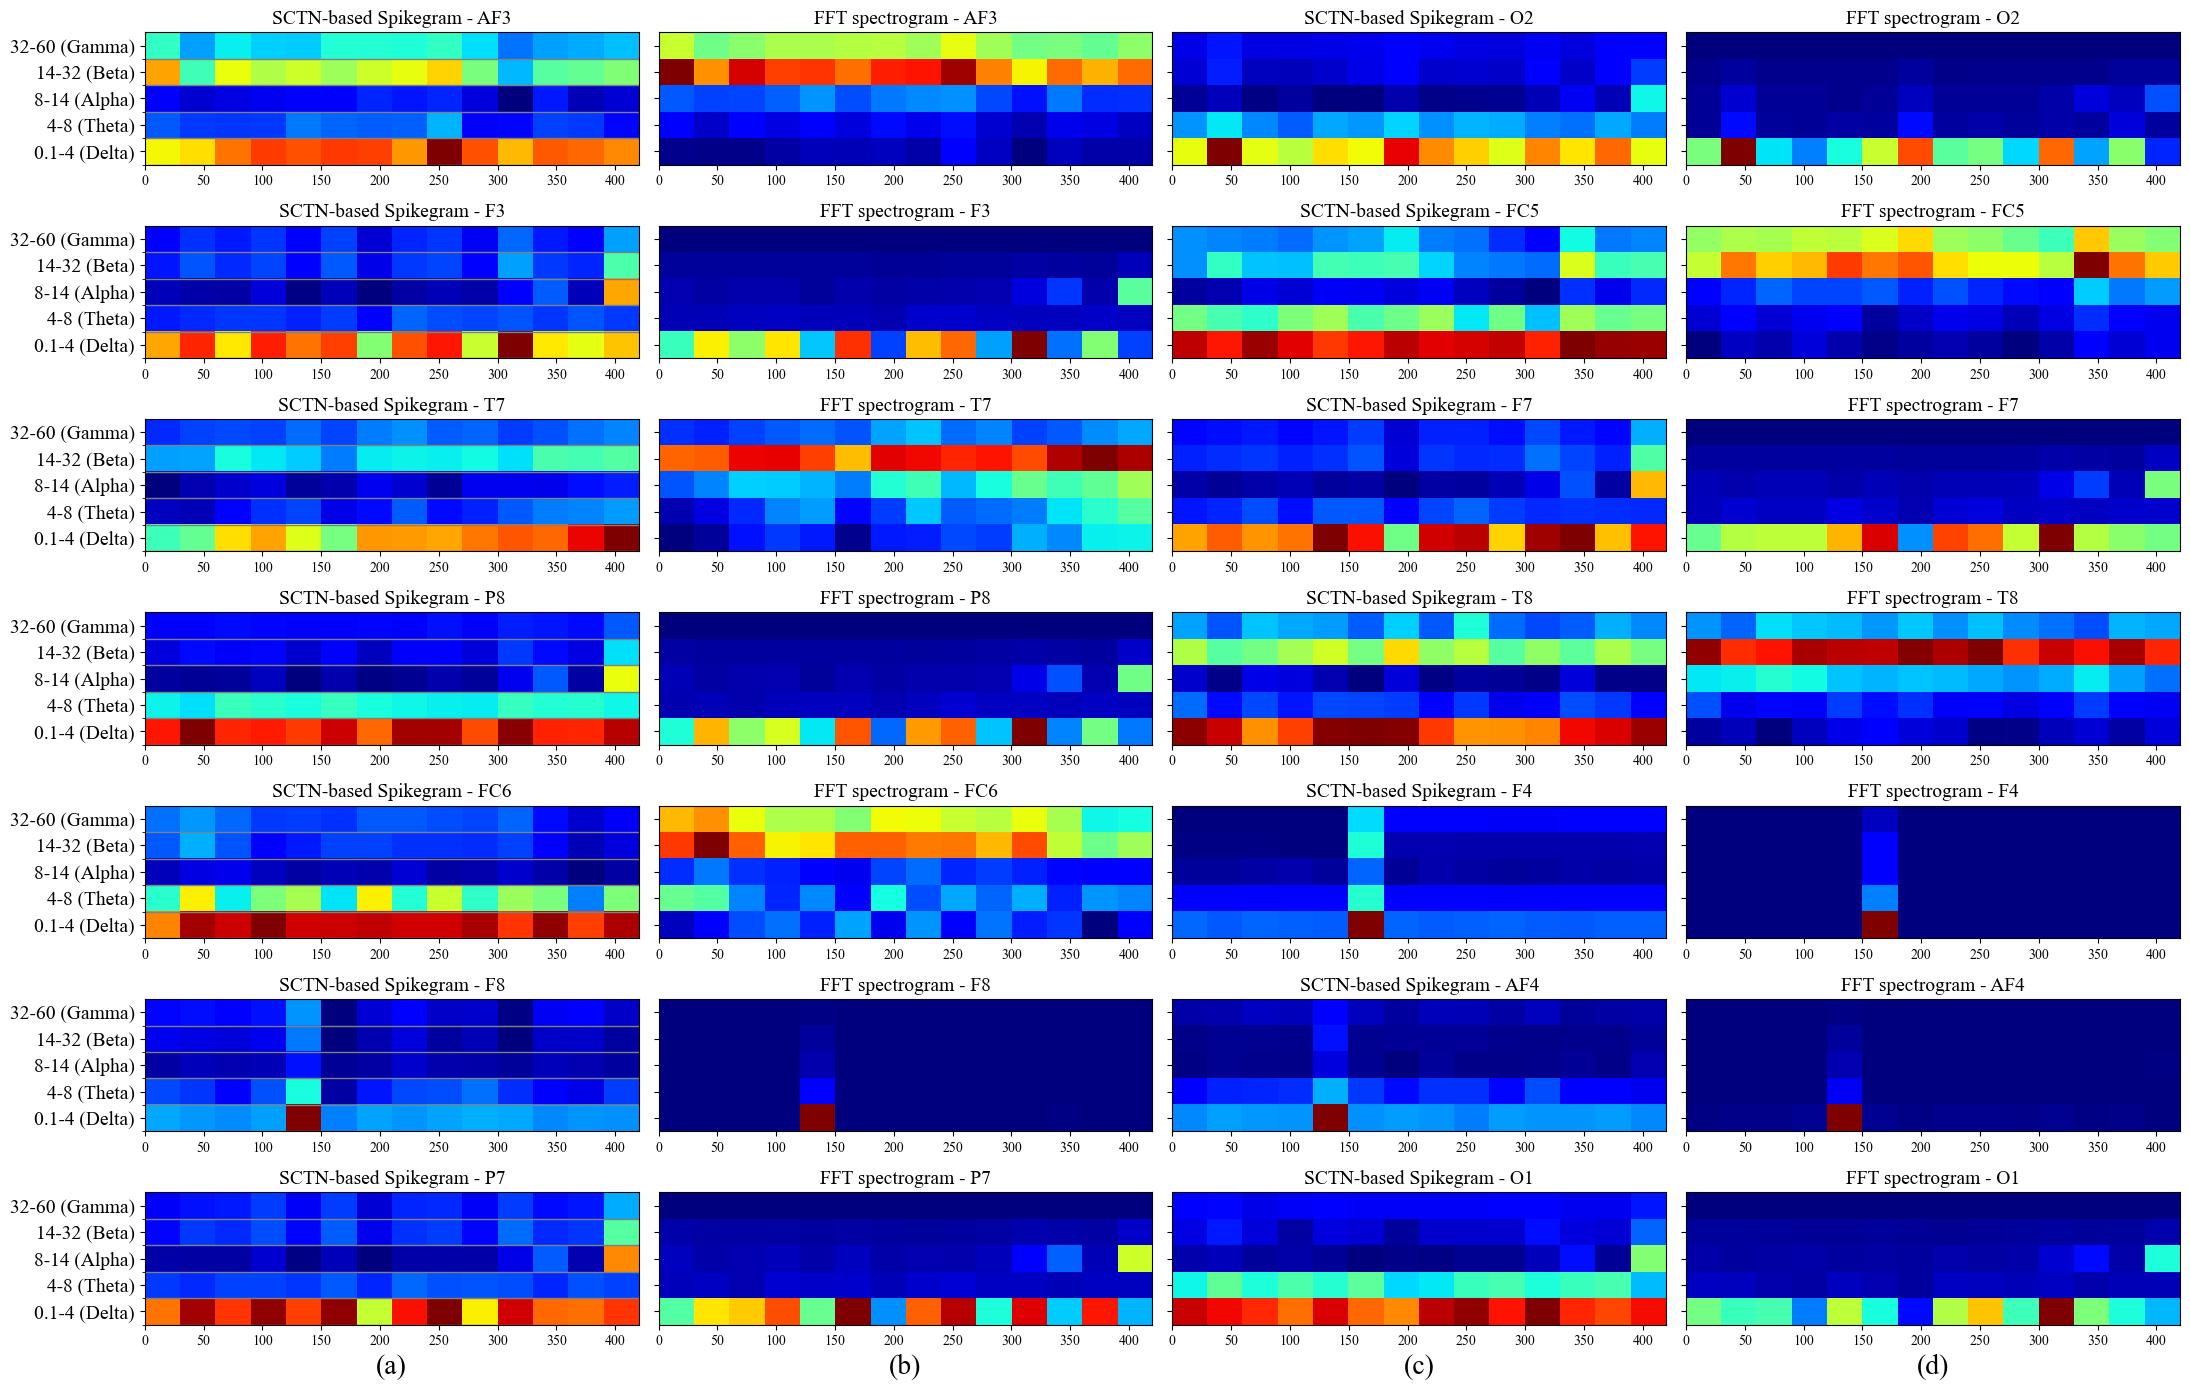

In [18]:
fig, axs = plt.subplots(7, 4, figsize=(22, 14))

for i, (ch, bin_specgram) in enumerate(spikes_bands_spectrogram.items()):
    labels = []
    if i%2 == 0:
        j = 0
        labels = ['0.1-4', '4-8', '8-14', '14-32', '32-60']
        labels = [f'{f} ({band})' for f, band in  zip(labels, bands.keys())]
    else:
        j = 2
    plot_bins(bin_specgram, duration, labels, annotate=False, rotate_annotate=True,
                   show=False, colorbar=False, gridlines=True, axs=axs[i//2][j], fig=fig, fontsize=14
              )
    axs[i//2][j].set_title(f'SCTN-based Spikegram - {ch}', fontsize=14)
    if i == 12:
        axs[i//2][j].set_xlabel(f'(a)', fontsize=20)
    if i == 13:
        axs[i//2][j].set_xlabel(f'(c)', fontsize=20)

for i, ch in enumerate(channels):
    ax = axs[i//2][i%2]
    if i%2 == 0:
        j = 1
    else:
        j = 3
    plot_bins(fft_bin_spectogram[ch], duration, [], annotate=False, rotate_annotate=True,
                   show=False, colorbar=False, gridlines=True, axs=axs[i//2][j], fontsize=14, fig=fig
              )
    axs[i//2][j].set_title(f'FFT spectrogram - {ch}', fontsize=14)
    if i == 12:
        axs[i//2][j].set_xlabel(f'(b)', fontsize=20)
    if i == 13:
        axs[i//2][j].set_xlabel(f'(d)', fontsize=20)

plt.tight_layout()



In [19]:
import matplotlib
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt


def pol2cart(x, y):
    x_rad = np.radians(x)
    xx = y * np.cos(x_rad)
    yy = y * np.sin(x_rad)
    return xx, yy


def topography_map_(dat, fig=None, ax=None, feature='std', vmin=0, vmax=1):
    feature = feature.lower()
    fig = fig or plt.figure()
    ax = ax or fig.add_subplot(111, aspect = 1)

    my_dat = np.transpose(np.array(dat))
    eeg_features = np.stack([
        np.min(my_dat, axis=1),
        np.max(my_dat, axis=1),
        np.std(my_dat, axis=1),
        np.mean(my_dat, axis=1),
        np.median(my_dat, axis=1),
        np.var(my_dat, axis=1),
    ], axis=0)


    chs = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    features =['min', 'max', 'std', 'mean', 'median', 'var']
    df0=pd.DataFrame(np.transpose(eeg_features), columns=features, index=chs)


    df=df0.reset_index().copy()
    df.rename(columns={'index':'channel'}, inplace=True)

    bio_semi_64 = [
        {'num': 1.0, 'x': -25.0, 'y': 0.3494, 'channel': 'AF3'},
        {'num': 2.0, 'x': -54.0, 'y': 0.4344, 'channel': 'F7'},
        {'num': 3.0, 'x': -39.0, 'y': 0.2833, 'channel': 'F3'},
        {'num': 4.0, 'x': -69.0, 'y': 0.340, 'channel': 'FC5'},
        {'num': 5.0, 'x': -90.0, 'y': 0.4344, 'channel': 'T7'},
        {'num': 6.0, 'x': 234.0, 'y': 0.4344, 'channel': 'P7'},
        {'num': 7.0, 'x': 198.0, 'y': 0.4344, 'channel': 'O1'},
        {'num': 8.0, 'x': 162.0, 'y': 0.4344, 'channel': 'O2'},
        {'num': 9.0, 'x': 126.0, 'y': 0.4344, 'channel': 'P8'},
        {'num': 10.0, 'x': 90.0, 'y': 0.4344, 'channel': 'T8'},
        {'num': 11.0, 'x': 69.0, 'y': 0.340, 'channel': 'FC6'},
        {'num': 12.0, 'x': 39.0, 'y': 0.2833, 'channel': 'F4'},
        {'num': 13.0, 'x': 54.0, 'y': 0.4344, 'channel': 'F8'},
        {'num': 14.0, 'x': 25.0, 'y': 0.3494, 'channel': 'AF4'}
    ]

    bio_semi_64 = pd.DataFrame(bio_semi_64)

    mn = bio_semi_64.merge(df[['channel', feature]], on='channel')
    xx, yy = pol2cart(mn['x'].tolist(), mn['y'].tolist())

    N=300
    z = mn[feature]

    xi = np.linspace(np.min(xx), np.max(xx), N)
    yi = np.linspace(np.min(yy), np.max(yy), N)
    zi = scipy.interpolate.griddata((xx, yy), z, (xi[None,:], yi[:,None]), method='cubic')

    xy_center = [0,0]   # center of the plot
    radius = 0.45          # radius

    # set points > radius to not-a-number. They will not be plotted.
    # the dr/2 makes the edges a bit smoother
    dr = xi[1] - xi[0]
    for i in range(N):
        for j in range(N):
            r = np.sqrt((xi[i] - xy_center[0])**2 + (yi[j] - xy_center[1])**2)
            if (r - dr/2) > radius:
                zi[j,i] = "nan"

    vmin = vmin or zi[~np.isnan(zi)].min()
    vmax = vmax or zi[~np.isnan(zi)].max()

    # return np.nanmin(zi), np.nanmax(zi)
    # use different number of levels for the fill and the lines
    levels = np.linspace(vmin, vmax, 60)
    CS = ax.contourf(xi, yi, zi, levels=levels, cmap=plt.cm.jet, zorder=1)
    levels = np.linspace(vmin, vmax, 15)
    ax.contour(xi, yi, zi, levels=levels, colors="grey", zorder=2)

    # make a color bar
    cbar = fig.colorbar(CS, ax=ax)
    cbar.ax.tick_params(size=0)
    cbar.set_ticks([])
    # add the data points
    # I guess there are no data points outside the head...
    ax.scatter(xx, yy, marker = 'o', c = 'b', s = 15, zorder = 3)
    for i, txt in enumerate(mn['channel'].tolist()):
        ax.annotate(txt, (xx[i], yy[i]))

    # Add some body parts. Hide unwanted parts by setting the zorder low
    # add two ears
    circle = matplotlib.patches.Ellipse(xy = [0,-0.45], width = 0.1, height = 0.05, angle = 0, edgecolor = "k", facecolor = "w", zorder = 0)
    ax.add_patch(circle)
    circle = matplotlib.patches.Ellipse(xy = [0,0.45], width = 0.1, height = 0.05, angle = 0, edgecolor = "k", facecolor = "w", zorder = 0)
    ax.add_patch(circle)
    # add a nose
    # xy = [[-0.05,0.425], [0,0.475],[0.05,0.425]]
    xy = [[0.425,-0.05], [0.475,0.0],[0.425,0.05]]
    polygon = matplotlib.patches.Polygon(xy = xy,edgecolor = "k", facecolor = "w", zorder = 0)
    ax.add_patch(polygon)

    return fig, CS

def spectograms_dict_to_bands(spec_dicts):
    """
    :param spec_dicts: dictionary of arrays where the keys are channels and the values are arrays of (5, N)
    :return: dict of dicts: main dict keys are bands, secondary dicts are ch.
    """
    res = {}
    for i, band in enumerate(bands.keys()):
        res[band] = {}
        for ch, specctogram in spec_dicts.items():
            res[band][ch] = (specctogram[i] - specctogram.min()) / specctogram.max()
    return res

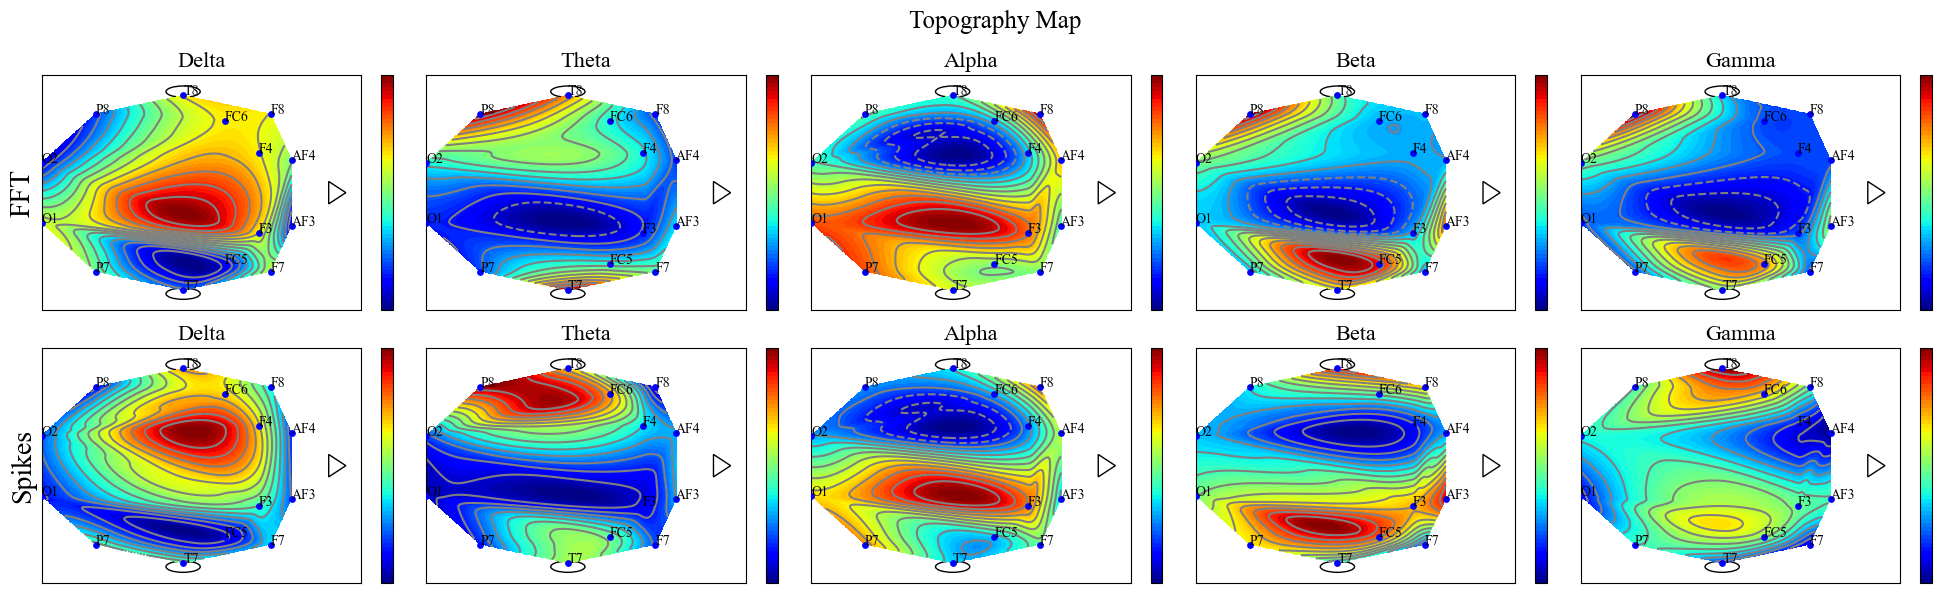

In [20]:
fft_spectograms_by_bands = spectograms_dict_to_bands(fft_bin_spectogram)
fig, axs = plt.subplots(2, 5, figsize=(20, 6))
vmin = None
vmax = None
feature = 'std'
for i, (band, ch_dict) in enumerate(fft_spectograms_by_bands.items()):
    ax = axs[0, i]
    df = pd.DataFrame(ch_dict)
    topography_map_(df, vmin=vmin, vmax=vmax, fig=fig, ax=ax, feature=feature)
    ax.set_title(band, fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

axs[0, 0].set_ylabel('FFT', fontsize=20)

# spikes
spikes_spectograms_by_bands = spectograms_dict_to_bands(spikes_bands_spectrogram)
for i, (band, ch_dict) in enumerate(spikes_spectograms_by_bands.items()):
    ax = axs[1, i]
    df = pd.DataFrame(ch_dict)
    topography_map_(df, vmin=vmin, vmax=vmax, fig=fig, ax=ax, feature=feature)
    ax.set_title(band, fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
axs[1, 0].set_ylabel('Spikes', fontsize=20)
plt.suptitle('Topography Map', fontsize=18)
plt.tight_layout()


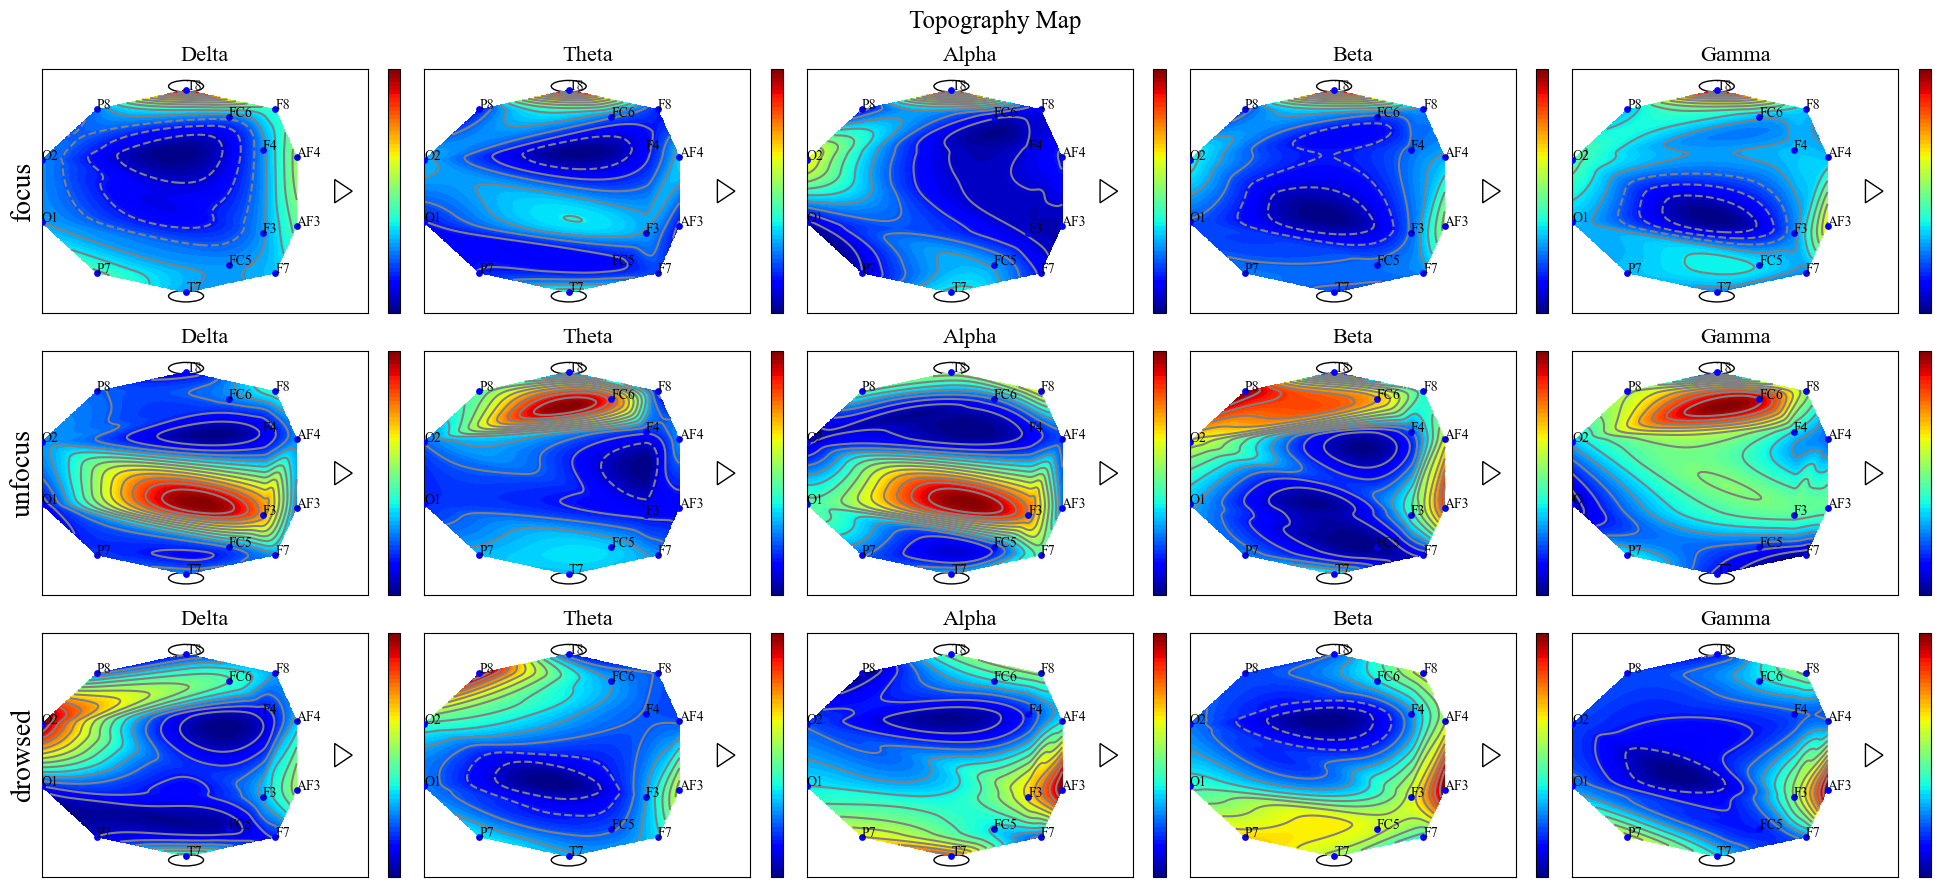

In [22]:
fig, axs = plt.subplots(3, 5, figsize=(20, 9))
feature = 'std'


base_minute, last_minute = 4, 5
for row, label in enumerate(['focus', 'unfocus', 'drowsed']):
    spikes_bands_spectrogram, spikes_vmin, spikes_vmax = bands_spikegrams(base_minute + row*10, last_minute + row*10)
    spikes_spectograms_by_bands = spectograms_dict_to_bands(spikes_bands_spectrogram)
    for i, (band, ch_dict) in enumerate(spikes_spectograms_by_bands.items()):
        ax = axs[row, i]
        df = pd.DataFrame(ch_dict)
        topography_map_(df, vmin=vmin, vmax=vmax, fig=fig, ax=ax, feature=feature)
        ax.set_title(band, fontsize=16)
        ax.set_xticks([])
        ax.set_yticks([])
        
    axs[row, 0].set_ylabel(label, fontsize=20)
    plt.suptitle('Topography Map', fontsize=18)
    plt.tight_layout()


## Training

In [4]:
import os
import torch
import math
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from typing import Tuple, Dict
from bindsnet.network import Network
from bindsnet.learning import PostPre
from bindsnet.network.monitors import Monitor
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.analysis.plotting import plot_spikes, plot_voltages
from bindsnet.network.topology import Connection, LocalConnection

full_resonator_array = torch.Tensor([
    1.1, 1.3, 1.6, 1.9, 2.2, 2.5,
    2.88, 3.05, 3.39, 3.7, 4.12, 4.62,
    5.09, 5.45, 5.87, 6.36, 6.8, 7.6,
    8.6, 10.5, 11.5, 12.8, 15.8, 16.6,
    19.4, 22.0, 24.8, 28.4, 30.5, 34.7,
    37.2, 40.2, 43.2, 47.7, 52.6, 57.2
    ])
bands = {
    'Delta': (.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 14),
    'Beta': (14, 32),
    'Gamma': (32, 62),
}


N = 11
xs = (np.array([-.7, -.66, 0, 0.2, 0.4, 0.5, 0.7, 0.7, 0.5, 0.4, 0.2, 0, -.66 ,-.7])+1)/2
ys = (-np.array([0.2, 0.6, .95, 0.6, 0.3, 0.6, 0.2, -0.2, -0.6, -0.3, -0.6, -.95, -0.6, -0.2])+1)/2
channels = ['O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', ]

ch_pos = {
    ch: (x, y)
    for ch, (x, y) in zip(channels, zip(ys, xs))
}

ch_pos_N = {k: (int(x * N), int(y * N)) for k, (x, y) in ch_pos.items()}
map_pos2ch = {(vx, vy): k for k, (vx, vy) in ch_pos_N.items()}
ch_pos_N

{'O2': (4, 1),
 'P8': (2, 1),
 'T8': (0, 5),
 'FC6': (2, 6),
 'F4': (3, 7),
 'F8': (2, 8),
 'AF4': (4, 9),
 'AF3': (6, 9),
 'F7': (8, 8),
 'F3': (7, 7),
 'FC5': (8, 6),
 'T7': (10, 5),
 'P7': (8, 1),
 'O1': (6, 1)}

In [5]:
class Resonators2BandsLayer(Network):

  def __init__(self, channel_name, band_name, clk_freq_resonators: torch.Tensor):
    super().__init__(dt=1)
    self.n_resonators = len(clk_freq_resonators)
    self.band_name = band_name
    self.channel_name = channel_name
    # Layers
    input_layer = Input(
        n=self.n_resonators, shape=(self.n_resonators, ), traces=True, tc_trace=20.0
    )

    agg_layer = LIFNodes(
        n=1,
        traces=False,
        rest=0.0,
        reset=3 * self.n_resonators,
        thresh=5 * self.n_resonators,
        tc_decay=60 * self.n_resonators,
        refrac=1,
    )
    w = torch.where(clk_freq_resonators == 153600, 1. , 11.)
    input_exc_conn = Connection(
            source=input_layer,
            target=agg_layer,
            w=w,
        )
    self.add_layer(input_layer, name=f"{channel_name}-{band_name}-resonators")
    self.add_layer(agg_layer, name=f"{channel_name}-{band_name}-band")

    self.add_connection(input_exc_conn, source=f"{channel_name}-{band_name}-resonators", target=f"{channel_name}-{band_name}-band")

class Bands2TopographyLayer(Network):

  def __init__(self, band_name: str, ch_netowrks: dict, shape: Tuple, ch_pos: dict, sigma=1):
    super().__init__(dt=1)

    self.ch_netowrks = ch_netowrks
    self.band_name = band_name
    topography_layer = LIFNodes(
        shape=shape,
        n=math.prod(shape),
        traces=True,
        rest=0.0,
        thresh=4,
    )

    # add layers ch_network to topography network!
    for ch in ch_netowrks.keys():
      ch_network = ch_netowrks[ch]
      self.add_layer(ch_network.layers[f'{ch}-{band_name}-resonators'],
                     name=f'{ch}-{band_name}-resonators')
    for ch in ch_netowrks.keys():
      ch_network = ch_netowrks[ch]
      self.add_layer(ch_network.layers[f'{ch}-{band_name}-band'],
                     name=f'{ch}-{band_name}-band')

    self.add_layer(topography_layer, name=f"{band_name}-topography")
    for ch in ch_netowrks.keys():
      ch_network = ch_netowrks[ch]
      for (source, target), conn in ch_network.connections.items():
        self.add_connection(conn, source=source, target=target)

      output_ch_layer = ch_network.layers[f'{ch}-{band_name}-band']
      w = self.channel_weights(shape, center=ch_pos[ch], sigma=sigma)
      conn = Connection(
            source=output_ch_layer,
            target=topography_layer,
            w=w,
        )
      self.add_connection(conn, source=f'{ch}-{band_name}-band', target=f"{band_name}-topography")


  def channel_weights(self, kernel_shape, center, sigma=1):
    # Create an empty kernel
    weights = torch.zeros(kernel_shape)

    # Calculate the Gaussian values for the new kernel
    radius = (kernel_shape[0]-1)/2
    dr = 1
    xy_center = ((kernel_shape[0]-1)/2, (kernel_shape[1]-1)/2)
    for x in range(kernel_shape[0]):
        for y in range(kernel_shape[1]):
            distance_squared = (x - center[0])**2 + (y - center[1])**2
            weights[x, y] = np.exp(-distance_squared / (2 * sigma**2))

            r = np.sqrt((x - xy_center[0])**2 + (y - xy_center[1])**2)
            if (r - dr/2) > radius:
                weights[x, y] = 0

    # Normalize the kernel
    weights /= weights.max()
    # return weights
    return weights.view(1, -1)

class Topographies2SNN(Network):

  def __init__(self, topography_maps: Dict[str, Bands2TopographyLayer],
               fc1_neurons: int,
               fc2_neurons: int,
               output_neurons: int):
    super().__init__()
    self.topography_maps = topography_maps

    fc1_layer = LIFNodes(
        n=fc1_neurons,
        traces=True,
        rest=0.0,
        thresh=10,
    )
    self.add_layer(fc1_layer, name='fc1_layer')

    fc2_layer = LIFNodes(
        n=fc2_neurons,
        traces=True,
        rest=0.0,
        thresh=10,
    )
    self.add_layer(fc2_layer, name='fc2_layer')

    output_layer = LIFNodes(
        n=output_neurons,
        traces=True,
        rest=0.0,
        thresh=10,
    )
    self.add_layer(output_layer, name='output_layer')

    # add full bands module
    for band_name, topography_map in topography_maps.items():

      for layer_name, layer in topography_map.layers.items():
        self.add_layer(layer,
                       name=layer_name)
      for (source, target), conn in topography_map.connections.items():
          self.add_connection(conn,
                              source=source,
                              target=target)

      # Connections from topography to fc1
      # to do
      topography_layer = topography_map.layers[f'{band_name}-topography']
      w = 0.3 * torch.rand(topography_layer.n, fc1_neurons)
      fc1_conn = Connection(
          source=topography_layer,
          target=fc1_layer,
          w=w,
          update_rule=PostPre,
      )
      self.add_connection(fc1_conn,
                          source=f'{band_name}-topography',
                          target='fc1_layer')

    w = 0.3 * torch.rand(fc1_neurons, fc2_neurons)
    fc2_conn = Connection(
        source=fc1_layer,
        target=fc2_layer,
        w=w,
        update_rule=PostPre,
    )
    self.add_connection(fc2_conn,
                        source=f'fc1_layer',
                        target='fc2_layer')

    w = 0.3 * torch.rand(fc2_neurons, output_neurons)
    output_conn = Connection(
        source=fc2_layer,
        target=output_layer,
        w=w,
        update_rule=PostPre,
    )
    self.add_connection(output_conn,
                        source=f'fc2_layer',
                        target='output_layer')

bands2topographies = {}
for band, (lf, hf) in bands.items():
  resonators2band = {}
  for ch in ch_pos.keys():
    freqs = full_resonator_array[(full_resonator_array >= lf) &
                                 (full_resonator_array< hf)]
    clk_freqs = torch.where(freqs < 10, 15360, 153600)
    resonators2band[ch] = Resonators2BandsLayer(ch, band, clk_freqs)

  bands2topographies[band] = Bands2TopographyLayer(band, resonators2band, shape=(N, N), ch_pos=ch_pos_N)

snn = Topographies2SNN(bands2topographies, N * N, N * int(np.sqrt(N)), 3)

gpu = torch.cuda.is_available()
device = torch.device("cuda" if gpu else "cpu")
torch.set_num_threads(os.cpu_count() - 1)

snn.to(device)
None

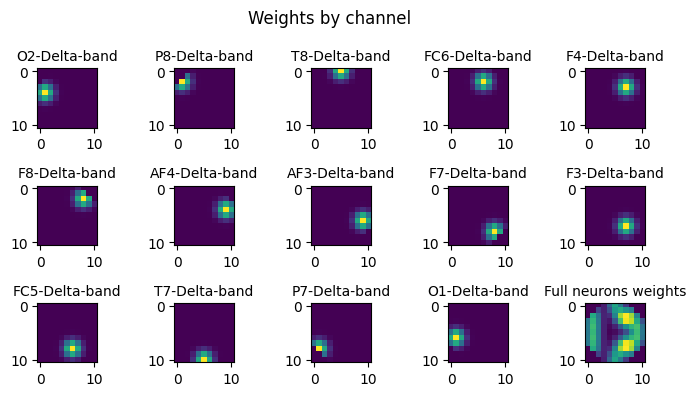

In [6]:
fig, axs = plt.subplots(3, 5, figsize=(7, 4))
i = 0
full_w = torch.zeros((N, N))
for (source_layer_name, target_layer_name), conn in bands2topographies['Delta'].connections.items():
  if not target_layer_name.endswith('topography'):
    continue
  ax = axs[i//5][i%5]
  ax.set_title(source_layer_name, fontsize=10)
  ax.imshow(conn.w.reshape(N,N).cpu())
  full_w += conn.w.reshape(N,N).cpu()
  i += 1

axs[2][4].set_title('Full neurons weights', fontsize=10)
axs[2][4].imshow(full_w)
plt.suptitle('Weights by channel')
plt.tight_layout()
plt.show()

In [7]:
import altair as alt
import pandas as pd
alt.data_transformers.enable('default', max_rows=None)


N = 22

xs = (np.array([-.85, -.66, 0, 0.2, 0.4, 0.7, 0.85,
                0.85, 0.7, 0.4, 0.2, 0, -.66 ,-.85])+1)/2
ys = (-np.array([0.2, 0.6, .95, 0.6, 0.3, 0.6, 0.2,
                 -0.2, -0.6, -0.3, -0.6, -.95, -0.6, -0.2])+1)/2
channels = ['O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4',
            'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', ]

ch_pos = {
    ch: (x, y)
    for ch, (x, y) in zip(channels, zip(ys, xs))
}

ch_pos_N = {k: (int(x * N), int(y * N)) for k, (x, y) in ch_pos.items()}
map_pos2ch = {(vx, vy): k for k, (vx, vy) in ch_pos_N.items()}
gamma_topography = Bands2TopographyLayer('Gamma', resonators2band, shape=(22, 22), ch_pos=ch_pos_N, sigma=N/9)

Ws = []
for (source_layer_name, target_layer_name), conn in gamma_topography.connections.items():
  if not target_layer_name.endswith('topography'):
    continue
  for i, w in enumerate(conn.w.tolist()[0]):
    try:
      t = map_pos2ch[(i // N, i % N)]
    except KeyError:
      t= ''
    Ws.append({
        'ch': source_layer_name.split('-')[0],
        'x': i % N,
        'y': i // N,
        'w': w,
        'T': t,
    })
    
df = pd.DataFrame(Ws)
range_ = [
   "#7047F5", "#43D6DE", "#5EF556", "#637939", "#E0CF46", "#FF9E4D", "#FA5445",
   "#46E099", "#01FF4B", "#FF4DDC", "#E6A32F", "#8BD4E0", "#FFD2B0", "#61CCFA",
]
main_chart = alt.Chart(df).mark_rect(
).encode(
    x=alt.X('x:N',
         axis=None
    ),
    y=alt.Y('y:N',
         axis=None
    ),
    color=alt.Color('ch', legend=None,
                    scale=alt.Scale(domain=channels, range=range_)),
    opacity=alt.Opacity('w', scale=alt.Scale(range=[0, 1]), legend=None)
)
text_chart = alt.Chart(df).mark_text(
).encode(
    x='x:N',
    y='y:N',
    text='T',
)

chart = (
    main_chart + text_chart
).properties(
    width=450,
    height=450
)

chart.show()

alt.LayerChart(...)